In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import string
import re
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
import warnings

warnings.filterwarnings ('ignore')
import random as random

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df=pd.read_csv(f'reviews_data.csv', encoding='utf-8')
df.head()

#check missing ratio
df_na = (df.isnull().sum() / len(df)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data.head(20)

def clean_data(df):
    df = df.dropna()
    df = df.drop(columns=['Image_Links'])
    df = df.rename(columns={'name': 'Name'})
    df.insert(2, "City", df["location"].str.split(",").str[0])
    df['Date'] = df['Date'].str.replace("Reviewed", "", case=False, regex=False)
    df = df.astype({'Date': 'datetime64[ns]'})
    df = df.astype({'Rating': 'int64'})
    df = df.drop(columns=['location'])

    return df

df_clean = clean_data(df.copy())

In [3]:
df_clean['Month'] = df_clean['Date'].dt.month
df_clean['Year'] = df_clean['Date'].dt.year
df_clean['DayOfWeek'] = df_clean['Date'].dt.dayofweek
#Clean Review
stopword=set(stopwords.words('english'))
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
df_clean["Review"] = df_clean["Review"].apply(clean)

In [4]:

def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df_clean['Sentiment'] = df_clean['Review'].apply(get_sentiment)

sentiment_counts = df_clean['Sentiment'].value_counts()
print(sentiment_counts)

Sentiment
Positive    282
Neutral     275
Negative    148
Name: count, dtype: int64


In [11]:
# Create a DataFrame with counts of each rating
Rating_counts_df = df_clean['Rating'].value_counts().sort_index().reset_index()
Rating_counts_df.columns = ['Rating', 'Number of Reviews']

fig = px.bar(
    Rating_counts_df,
    x='Rating',
    y='Number of Reviews',
    title='<b>Distribution of Customer Ratings</b>', 
    color='Rating',
    color_continuous_scale=px.colors.sequential.Sunset, 
    category_orders={"Rating": sorted(df_clean['Rating'].unique())}, 
    labels={'Rating': 'Rating'} 
)

# Update layout for better aesthetics
fig.update_layout(
    xaxis_title='<b>Rating</b>',
    yaxis_title='<b>Number of Reviews</b>',
    font=dict(family="Arial", size=12, color="DarkSlateGray"), 
    title_x=0.5, 
    plot_bgcolor='white',
    paper_bgcolor='white', 
    bargap=0.2, 
    hovermode="x unified", 
    margin=dict(l=40, r=40, t=80, b=40), 
    xaxis = dict(
        tickmode = 'linear', 
        dtick = 1 
    )
)

# Show the figure
fig.show()

In [6]:
sentiment_colors = {
    'Positive': '#b0f2b4',  
    'Neutral': "#baf2e9",   
    'Negative': '#ff7477'   
}

# Prepare data for plotting
sentiment_counts_df = sentiment_counts.reset_index()
sentiment_counts_df.columns = ['Sentiment', 'Number of Reviews']

fig = px.bar(
    sentiment_counts_df,
    x='Sentiment',
    y='Number of Reviews',
    title='<b>Distribution of Customer Sentiments</b>',  
    color='Sentiment',
    color_discrete_map=sentiment_colors,
    category_orders={"Sentiment": ['Positive', 'Neutral', 'Negative']}  
)


fig.update_layout(
    xaxis_title='<b>Sentiment</b>',
    yaxis_title='<b>Number of Reviews</b>',
    font=dict(family="Arial", size=12),
    title_x=0.5, 
    plot_bgcolor='white', 
    paper_bgcolor='white', 
    bargap=0.2, 
    hovermode="x unified", 
    margin=dict(l=40, r=40, t=80, b=40) 
)

fig.show()

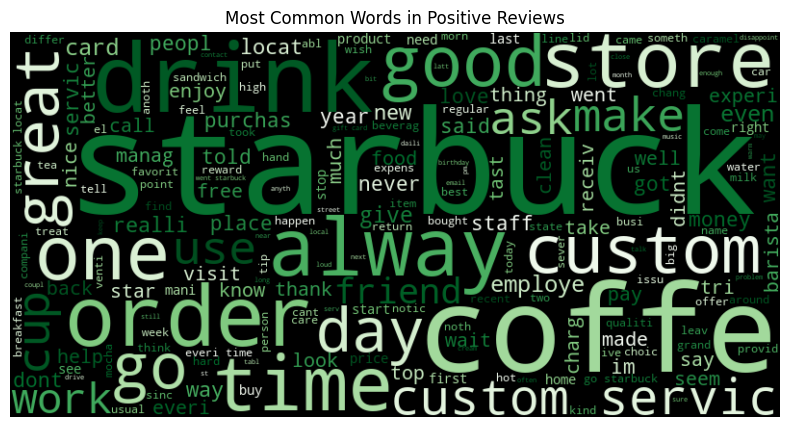

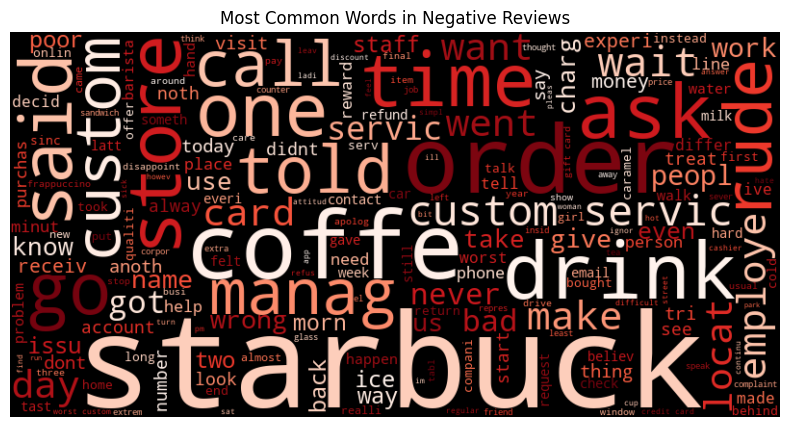

In [7]:
positive_reviews = ' '.join(df_clean[df_clean['Sentiment'] == 'Positive']['Review'])
negative_reviews = ' '.join(df_clean[df_clean['Sentiment'] == 'Negative']['Review'])

# WordClouds
wordcloud_pos = WordCloud(width=800, height=400, background_color='black', colormap='Greens').generate(positive_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_reviews)

# Plot positive
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Most Common Words in Positive Reviews')
plt.axis('off')
plt.show()

# Plot negative
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Most Common Words in Negative Reviews')
plt.axis('off')
plt.show()

In [8]:
# Get the top 30 categories by frequency
top_30_categories = df_clean['City'].value_counts().head(30)
    
# Create a DataFrame for the top 30 categories and their frequencies
top_30_df = pd.DataFrame({'Category': top_30_categories.index, 'Frequency': top_30_categories.values})
    
fig = px.bar(
        top_30_df,
        x='Category',
        y='Frequency',
        title=f'Top 30 Categories in {'City'}',
        labels={'Category': 'City', 'Frequency': 'Frequency'},
        color='Category',
        color_discrete_sequence=px.colors.qualitative.Set3  
    )
    
fig.update_layout(
        xaxis=dict(title='City'),
        yaxis=dict(title='Frequency'),
        xaxis_tickangle=-90,  
        showlegend=False  
    )
    
fig.show()

In [9]:
day_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
daily_rating = df_clean.groupby(['DayOfWeek'])['Rating'].sum().reset_index()

# Choose colors manually from Set3 or Sunset
set3_colors = px.colors.qualitative.Set3


# First bar chart 
fig = px.bar(
    daily_rating,
    x='DayOfWeek',
    y='Rating',
    labels={'DayOfWeek': 'Day of Week', 'Rating': 'Total Rating'},
    title='Total Rating Count Per Day '
)

fig.update_traces(
    marker_color=set3_colors,  
    marker_line_color=None, 
    marker_line_width=1
)

fig.update_xaxes(
    tickmode='array',
    tickvals=daily_rating['DayOfWeek'].unique(),
    ticktext=day_names
)
fig.show()

# Line chart: Total Rating Count Per Month 
annual_rating = df_clean.groupby(['Month'])['Rating'].sum().reset_index()
fig = px.line(
    annual_rating,
    x='Month',
    y='Rating',
    labels={'Month': 'Month', 'Rating': 'Total Rating'},
    title='Total Rating Count Per Month',
    color_discrete_sequence=px.colors.sequential.Sunset_r  
)
fig.show()

# Line chart: Total Rating Count Per Year 
annual_rating = df_clean.groupby(['Year'])['Rating'].sum().reset_index()
fig = px.line(
    annual_rating,
    x='Year',
    y='Rating',
    labels={'Year': 'Year', 'Rating': 'Total Rating'},
    title='Total Rating Count Per Year',
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.show()

<Figure size 1200x600 with 0 Axes>

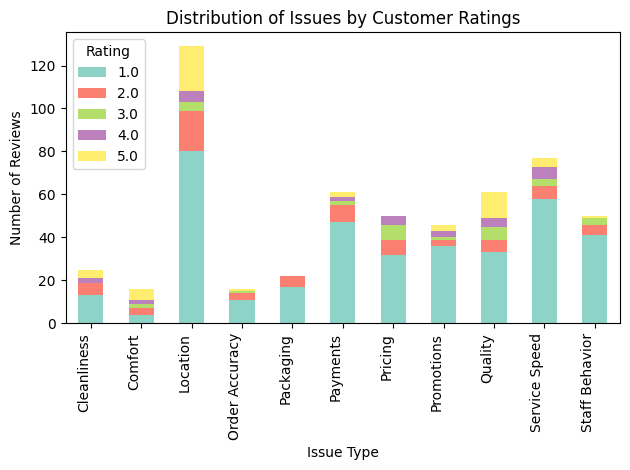

In [10]:
issue_keywords = {
    "Service": {
        "Staff Behavior": ["rude", "unfriendly", "attitude", "ignore", "arrogant",
                           "not patient", "didn't listen", "not helpful", "bad attitude"],
        "Service Speed": ["slow", "wait", "long time", "minutes", "speed",
                          "long line", "took forever", "waited too long", "delayed"],
        "Order Accuracy": ["wrong order", "mistake", "incorrect", "forgot", "missing",
                           "wrong drink", "incorrect syrup", "didn't follow instructions"]
    },
    "Product": {
        "Quality": ["taste", "quality", "fresh", "delicious", "awful",
                    "too sweet", "overpowered sweetness", "no flavor", "tasteless"],
        "Packaging": ["broken", "lid", "spill", "leak", "container",
                      "broken glass", "cracked cup", "container broken", "spilled easily"]
    },
    "Experience": {
        "Cleanliness": ["dirty", "clean", "hygiene", "messy", "sanitation",
                        "sticky counters", "coffee stains", "never cleaned", "germs"],
        "Comfort": ["comfortable", "noisy", "crowded", "atmosphere", "space",
                    "too loud", "loud music", "can't hear", "noise problem"],
        "Location": ["location", "parking", "access", "find", "place",
                     "hard to find", "no parking", "inconvenient", "far away"]
    },
    "Finance": {
        "Pricing": ["expensive", "price", "overpriced", "cost", "cheap",
                    "not worth it", "wasting money", "cost more than expected"],
        "Payments": ["payment", "charge", "refund", "credit", "cash",
                     "mobile order failed", "app issue", "charged twice", "extra charge"],
        "Promotions": ["promotion", "offer", "discount", "deal", "reward",
                       "free drink", "birthday reward", "gift card issue"]
    }
}

def detect_issues(text):
    text = str(text).lower()
    issues = []
    for main_cat, sub_cats in issue_keywords.items():
        for sub_cat, keywords in sub_cats.items():
            if any(f' {kw} ' in f' {text} ' for kw in keywords):
                issues.append(f"{main_cat} - {sub_cat}")
    return ', '.join(issues) if issues else 'No specific issues'

# Apply issue detection
df['Issues'] = df['Review'].apply(detect_issues)

# Enhanced issue classification function
def classify_issues(review):
    review = str(review).lower()
    issues = []
    
    # Analyze each category
    for main_cat, sub_cats in issue_keywords.items():
        for sub_cat, keywords in sub_cats.items():
            if any(f" {kw} " in f" {review} " for kw in keywords):
                issues.append({
                    'Main Category': main_cat,
                    'Issue': sub_cat,
                    'Keywords': ', '.join([kw for kw in keywords if f" {kw} " in f" {review} "])
                })
    
    return issues

# Process all reviews
all_issues = []
for _, row in df.iterrows():
    issues = classify_issues(row['Review'])
    for issue in issues:
        issue['Rating'] = row['Rating']
        all_issues.append(issue)

issues_df = pd.DataFrame(all_issues)

# Advanced Treemap Visualization
if not issues_df.empty:
    # Calculate frequencies
    freq_df = issues_df.groupby(['Main Category', 'Issue']).size().reset_index(name='Count')
    
    fig = px.treemap(freq_df,
                     path=['Main Category', 'Issue'],
                     values='Count',
                     title='Distribution of Customer Issues in Starbucks Reviews',
                     color='Count',
                     color_continuous_scale='Sunset',
                     hover_data=['Issue', 'Count'])
    
    fig.update_traces(textinfo="label+value+percent parent")
    fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
    fig.show()

# Relationship Between Issues and Ratings (Stacked Bar Chart)
plt.figure(figsize=(12, 6))
issues_by_rating = issues_df.groupby(['Issue', 'Rating']).size().unstack().fillna(0)
issues_by_rating.plot(kind='bar', stacked=True, colormap='Set3')
plt.title('Distribution of Issues by Customer Ratings')
plt.xlabel('Issue Type')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.legend(title='Rating')
plt.show()
